<a href="https://colab.research.google.com/github/NihalPuram/Stock_Price_Model/blob/master/Stock_Project_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a program that uses a artificial reccurant neural network called long short term memory (LSTM) to predict the stock price (ie for example we have the stock price of Coca-cola)

# Gathering Data

This is our first step in gathering data. Iam using the tiingo api to download the data. For you to run this, simply login to tiingo's website and enter your api_key. Change the "stock" variable to change the stock you are viewing.

In [1]:
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
stock = "Enter your stock ticker"

In [3]:
df = pdr.get_data_tiingo(stock,api_key='enter your tiingo api-key')

In [4]:
df.to_csv('DATA.csv')

In [5]:
import pandas as pd

df = pd.read_csv("DATA.csv")

In [6]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,KO,2015-09-11 00:00:00+00:00,38.13,38.19,37.84,38.01,11800440,32.634337,32.685689,32.386134,32.531632,11800440,0.33,1.0
1,KO,2015-09-14 00:00:00+00:00,38.10,38.22,37.85,38.22,8950014,32.608661,32.711365,32.394693,32.711365,8950014,0.00,1.0
2,KO,2015-09-15 00:00:00+00:00,38.50,38.63,37.92,38.07,13019802,32.951009,33.062272,32.454604,32.582984,13019802,0.00,1.0
3,KO,2015-09-16 00:00:00+00:00,39.15,39.19,38.47,38.67,22233131,33.507324,33.541559,32.925333,33.096507,22233131,0.00,1.0
4,KO,2015-09-17 00:00:00+00:00,39.38,39.61,39.04,39.15,21232475,33.704175,33.901025,33.413179,33.507324,21232475,0.00,1.0


In [7]:
df1=df.reset_index()['close']

In [8]:
df1.head()

0    38.13
1    38.10
2    38.50
3    39.15
4    39.38
Name: close, dtype: float64

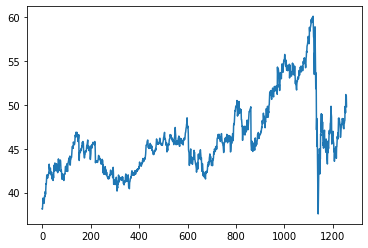

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1.shape

(1257, 1)

In [12]:
df1

array([[0.02525476],
       [0.02392556],
       [0.04164821],
       ...,
       [0.57244129],
       [0.59725299],
       [0.54275587]])

# Train-Test split

Here we are spliting the data to a train and test set for initial training and validation. For the final model we will retrain using the complete dataset.

In [13]:
split_size = 0.80
train_size = int(len(df1)*split_size)
train_data,test_data = df1[0:train_size,:],df1[train_size:,:1]

In [14]:
len(test_data)

252

In [15]:
len(train_data)

1005

In [16]:
def create_dataset(dataset,time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

this function creates the dataset that contains the set previous values of the stock for a brief period of time. This allows the model to have a 'memory' of that particular time frame

In [17]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [18]:
X_train

array([[0.02525476, 0.02392556, 0.04164821, ..., 0.24102791, 0.21621622,
        0.22862206],
       [0.02392556, 0.04164821, 0.0704475 , ..., 0.21621622, 0.22862206,
        0.22020381],
       [0.04164821, 0.0704475 , 0.08063802, ..., 0.22862206, 0.22020381,
        0.21621622],
       ...,
       [0.40540541, 0.4067346 , 0.41825432, ..., 0.77492246, 0.7744794 ,
        0.78599911],
       [0.4067346 , 0.41825432, 0.41603899, ..., 0.7744794 , 0.78599911,
        0.80682322],
       [0.41825432, 0.41603899, 0.43066017, ..., 0.78599911, 0.80682322,
        0.77802393]])

In [19]:
print(y_train.shape)
print(X_train.shape)

(904,)
(904, 100)


The next cell reshapes the data to a 3 dimensions, LSTM's require this.

In [20]:
#reshape data to be [sample,time_ steps,features] ie 3 dimensions
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# Create LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Dropout
model = Sequential()
model.add(Bidirectional(LSTM(50,return_sequences = True), input_shape = (time_step,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 100)          20800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 512)               26112     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=2)

Epoch 1/100
15/15 - 3s - loss: 0.0263 - val_loss: 0.0555
Epoch 2/100
15/15 - 1s - loss: 0.0147 - val_loss: 0.0450
Epoch 3/100
15/15 - 1s - loss: 0.0068 - val_loss: 0.0308
Epoch 4/100
15/15 - 1s - loss: 0.0042 - val_loss: 0.0380
Epoch 5/100
15/15 - 1s - loss: 0.0031 - val_loss: 0.0260
Epoch 6/100
15/15 - 1s - loss: 0.0027 - val_loss: 0.0247
Epoch 7/100
15/15 - 1s - loss: 0.0024 - val_loss: 0.0218
Epoch 8/100
15/15 - 1s - loss: 0.0021 - val_loss: 0.0204
Epoch 9/100
15/15 - 1s - loss: 0.0020 - val_loss: 0.0191
Epoch 10/100
15/15 - 1s - loss: 0.0024 - val_loss: 0.0182
Epoch 11/100
15/15 - 1s - loss: 0.0019 - val_loss: 0.0189
Epoch 12/100
15/15 - 1s - loss: 0.0020 - val_loss: 0.0154
Epoch 13/100
15/15 - 1s - loss: 0.0018 - val_loss: 0.0158
Epoch 14/100
15/15 - 1s - loss: 0.0015 - val_loss: 0.0150
Epoch 15/100
15/15 - 1s - loss: 0.0015 - val_loss: 0.0146
Epoch 16/100
15/15 - 1s - loss: 0.0014 - val_loss: 0.0139
Epoch 17/100
15/15 - 1s - loss: 0.0014 - val_loss: 0.0129
Epoch 18/100
15/15 - 1s

In [24]:
final_train,final_test = create_dataset(df1,100)

In [25]:
#reshape
final_train = final_train.reshape(final_train.shape[0],final_train.shape[1],1)

In [26]:
model.fit(final_train,final_test,epochs=100,batch_size=64,verbose=2)

Epoch 1/100
19/19 - 2s - loss: 0.0015
Epoch 2/100
19/19 - 2s - loss: 0.0014
Epoch 3/100
19/19 - 2s - loss: 0.0018
Epoch 4/100
19/19 - 2s - loss: 0.0020
Epoch 5/100
19/19 - 2s - loss: 0.0017
Epoch 6/100
19/19 - 2s - loss: 0.0015
Epoch 7/100
19/19 - 2s - loss: 0.0015
Epoch 8/100
19/19 - 2s - loss: 0.0014
Epoch 9/100
19/19 - 2s - loss: 0.0016
Epoch 10/100
19/19 - 2s - loss: 0.0015
Epoch 11/100
19/19 - 2s - loss: 0.0015
Epoch 12/100
19/19 - 2s - loss: 0.0015
Epoch 13/100
19/19 - 2s - loss: 0.0014
Epoch 14/100
19/19 - 2s - loss: 0.0014
Epoch 15/100
19/19 - 2s - loss: 0.0013
Epoch 16/100
19/19 - 2s - loss: 0.0018
Epoch 17/100
19/19 - 2s - loss: 0.0014
Epoch 18/100
19/19 - 2s - loss: 0.0014
Epoch 19/100
19/19 - 2s - loss: 0.0013
Epoch 20/100
19/19 - 2s - loss: 0.0013
Epoch 21/100
19/19 - 2s - loss: 0.0014
Epoch 22/100
19/19 - 2s - loss: 0.0013
Epoch 23/100
19/19 - 2s - loss: 0.0014
Epoch 24/100
19/19 - 2s - loss: 0.0014
Epoch 25/100
19/19 - 2s - loss: 0.0013
Epoch 26/100
19/19 - 2s - loss: 0.

# Predict the plot outcome

In [27]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [28]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train,train_predict))

0.020005004603423537

In [29]:
np.sqrt(mean_squared_error(y_test,test_predict))

0.05170510731433499

In [30]:
len(test_data)

252

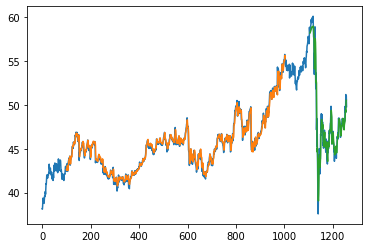

In [31]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()

# Predict the next 30 days

In [32]:
len(test_data)

252

In [33]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
days = 30
while(i<days):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,101+days)

In [37]:
len(df1)

1257

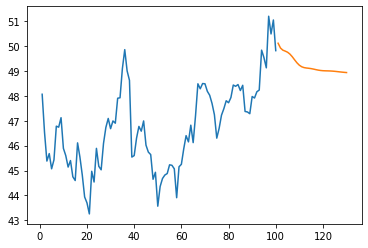

In [38]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

These are the results

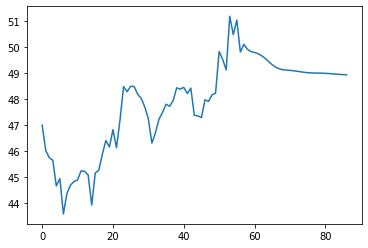

In [39]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(scaler.inverse_transform(df3[1200:]))

These are the results rounded to the last 100 days

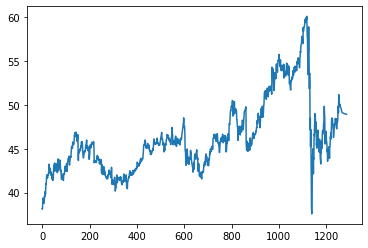

In [40]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

this is the entire dataset included our predicted results

In [41]:
output = np.array(temp_input[-30:])
output = scaler.inverse_transform(output.reshape(-1,1))
output

array([[50.10725442],
       [49.91555785],
       [49.82999286],
       [49.79137938],
       [49.74726775],
       [49.67218785],
       [49.56593385],
       [49.44039666],
       [49.32037644],
       [49.22556402],
       [49.16350236],
       [49.12971842],
       [49.11322264],
       [49.1024389 ],
       [49.08879645],
       [49.069898  ],
       [49.04869106],
       [49.02909037],
       [49.01414569],
       [49.00510409],
       [49.00063508],
       [48.99804945],
       [48.99468088],
       [48.98889888],
       [48.98044651],
       [48.97008115],
       [48.95915347],
       [48.94882174],
       [48.93953798],
       [48.93115825]])

these are the predicted values

These results are purely arbitrary and i dont think its reliable enough for someone to invest their money. Iam not responsible for anyone using this model for any financial uses.